# Github Counterfactual Analysis

In [1]:
import numpy as np
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt

from deep4cast.forecasters import Forecaster
import deep4cast.models as models
import deep4cast.custom_metrics as metrics
import deep4cast.utils as utils
import deep4cast.cv as cv

%matplotlib inline

Using TensorFlow backend.
/Users/toby/anaconda3/envs/deep_forecast/lib/python3.6/site-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.23) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


# Parameters

In [2]:
horizon = 90
lag = 2*horizon
filters = 64
num_layers = 2

# Data preparation

In [3]:
# Loading the dataset and dropping unncecessary columns
df = pd.read_pickle('../data/processed/github_total_push_events_2011-2018.pkl')
data = df.drop(['month', 'day', 'age'], axis=1)
data = data.dropna()

# Log transform targets
data['count'] = np.log1p(data['count'])

# We have real-valued and categorial features and we need to make sure that we do the data 
# preparation for them correctly
real_values = ['count']
categorical = list(set(data.columns).difference(set(real_values)))

# Let's create lagged real features to include information about past seasonal behavior
lagged = data[real_values].shift(365-horizon)
lagged = lagged.rename(columns={column:column + '_lagged' for column in lagged.columns})
data = pd.concat([data, lagged], axis=1)
data = data.dropna()
data = data.reset_index(drop=True)

# Let's shift the holidays back by the horizon length for better forecasting on holidays
data['holiday'] = data['holiday'].shift(-horizon)

# Training & testing boundary
test_ind = data.index.where(data['date'] == dt.datetime(2017,6,4)).dropna().astype('int').values[0]

# Counteractual indices
cf_ind = data.index.where(data['date'] == dt.datetime(2018,6,4)).dropna().astype('int').values[0]

# Create a numpy array drop date columns
data_arr = data.drop(['date'], axis=1)
data_arr = np.expand_dims(data_arr.values, 0)

# Now we need to sequentialize the training and testing dataset
X_train, y_train = utils.sequentialize(data_arr[:,:test_ind,:], lag, horizon, targets=[0])
X_test, y_test = utils.sequentialize(data_arr[:,test_ind-lag:cf_ind,:], lag, horizon, targets=[0])
X_cf, y_cf = utils.sequentialize(data_arr[:,cf_ind-lag-1:,:], lag, horizon, targets=[0])

# Rescale the datasets so that the neural networks can be fitted properly and stably
scaler = cv.VectorScaler(targets=[0, -1])
scaler.fit_x(X_train)
scaler.fit_y(y_train)
X_train = scaler.transform_x(X_train)
X_test = scaler.transform_x(X_test)
X_cf = scaler.transform_x(X_cf)
y_train = scaler.transform_y(y_train)
y_test = np.expm1(y_test)
y_cf = np.expm1(y_cf)

FileNotFoundError: [Errno 2] No such file or directory: '../data/processed/github_dau_2011-2018.pkl'

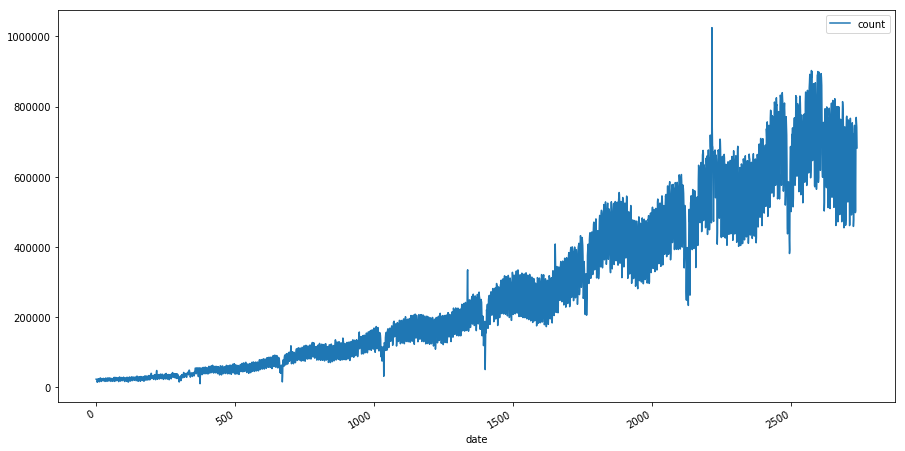

In [4]:
# Let plot the data to help our imagination
df[['count']].plot(subplots=True, figsize=(15, 8))
plt.xlabel('date')
plt.show()

# Modeling

In [5]:
model = models.WaveNet(filters=filters, num_layers=num_layers)

forecaster = Forecaster(
    model,
    lag=lag,  # This is the number of time steps used to predict the future for each data point
    horizon=horizon,  # This is how many time steps into the future we want to produce
    lr=0.001,  # This is the learning rate for the optimizer
    epochs=30
)

forecaster.fit(X_train, y_train, verbose=2)

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
Epoch 1/30
 - 1s - loss: 0.4623
Epoch 2/30
 - 1s - loss: -3.6682e-01
Epoch 3/30
 - 1s - loss: -8.6936e-01
Epoch 4/30
 - 1s - loss: -1.2730e+00
Epoch 5/30
 - 1s - loss: -1.6163e+00
Epoch 6/30
 - 1s - loss: -1.6530e+00
Epoch 7/30
 - 1s - loss: -1.7925e+00
Epoch 8/30
 - 1s - loss: -1.9248e+00
Epoch 9/30
 - 1s - loss: -2.0647e+00
Epoch 10/30
 - 1s - loss: -2.2956e+00
Epoch 11/30
 - 1s - loss: -2.3042e+00
Epoch 12/30
 - 1s - loss: -2.4119e+00
Epoch 13/30
 - 1s - loss: -2.5150e+00
Epoch 14/30
 - 1s - loss: -2.6983e+00
Epoch 15/30
 - 1s - loss: -2.7102e+00
Epoch 16/30
 - 1s - loss: -2.7521e+00
Epoch 17/30
 - 1s - loss: -2.8877e+00
Epoch 18/30
 - 1s - loss: -2.7876e+00
Epoch 19/30
 - 1s - loss: -3.0108e+00
Epoch 20/30
 - 1s - loss: -3.0236e+00
Epoch 21/30
 - 1s - loss: -3.0083e+00
Epoch 22/30
 - 1s - loss: -3.0386e+00
Epoch 23/30
 - 1s - loss: -3.2215e+00
Epoch 24/30
 - 1s - loss: -3.1727e+00
Epoch 25/30
 - 1s -

# Evaluation

In [6]:
# Training set evaluation
y_train_eval = np.expm1(scaler.inverse_transform_y(y_train[::horizon]))
y_train_eval = np.reshape(y_train_eval, y_train_eval.shape[0]*y_train_eval.shape[1])
y_train_eval = np.atleast_2d(y_train_eval).T

# Build prediction time series
samples = forecaster.predict(X_train[::horizon,:,:])
samples = scaler.inverse_transform_y(samples)
train_samples = []
for i in range(samples.shape[1]):
    train_samples.append(samples[:,i,:,:])
train_samples = np.concatenate(train_samples, axis=1)
train_samples = np.expm1(train_samples)
train_mean = np.mean(train_samples, axis=0)
train_lq = np.percentile(train_samples, q=5, axis=0)
train_uq = np.percentile(train_samples, q=95, axis=0)

# Training set days
train_dates = data.date[lag:train_mean.shape[0]+lag]

In [7]:
# Testing set evaluation
y_test_eval = y_test[::horizon]
y_test_eval = np.reshape(y_test_eval, y_test_eval.shape[0]*y_test_eval.shape[1])
y_test_eval = np.atleast_2d(y_test_eval).T

# Build prediction time series
samples = forecaster.predict(X_test[::horizon,:,:])
samples = scaler.inverse_transform_y(samples)
test_samples = []
for i in range(samples.shape[1]):
    test_samples.append(samples[:,i,:,:])
test_samples = np.concatenate(test_samples, axis=1)
test_samples = np.expm1(test_samples)
test_mean = np.mean(test_samples, axis=0)
test_lq = np.percentile(test_samples, q=5, axis=0)
test_uq = np.percentile(test_samples, q=95, axis=0)

# Test set days
test_dates = data.date[test_ind:test_mean.shape[0]+test_ind]

In [8]:
# Counterfactual set evaluation
y_cf_eval = y_cf[::horizon]
y_cf_eval = np.reshape(y_cf_eval, y_cf_eval.shape[0]*y_cf_eval.shape[1])
y_cf_eval = np.atleast_2d(y_cf_eval).T

# Build prediction time series
samples = forecaster.predict(X_cf[::horizon,:,:])
samples = scaler.inverse_transform_y(samples)
cf_samples = []
for i in range(samples.shape[1]):
    cf_samples.append(samples[:,i,:,:])
cf_samples = np.concatenate(cf_samples, axis=1)
cf_samples = np.expm1(cf_samples)
cf_mean = np.mean(cf_samples, axis=0)
cf_lq = np.percentile(cf_samples, q=5, axis=0)
cf_uq = np.percentile(cf_samples, q=95, axis=0)

# Test set days
cf_dates = data.date[cf_ind-1:cf_mean.shape[0]+cf_ind-1]

SMAPE: 5.02%
Pinball Score: 4697.92
Coverage: 


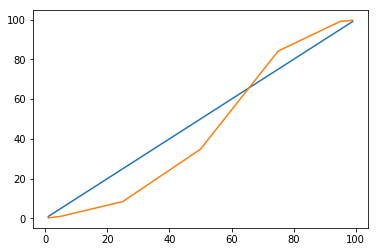

In [9]:
train_smape = metrics.smape(train_samples, y_train_eval)
train_cov, train_perc = metrics.coverage(train_samples, y_train_eval)
train_pinball = metrics.pinball_loss(train_samples, y_train_eval)

print('SMAPE: {}%'.format(train_smape))
print('Pinball Score: {}'.format(train_pinball))
print('Coverage: ')
plt.plot(train_perc, train_perc)
plt.plot(train_perc, train_cov)

SMAPE: 6.98%
Pinball Score: 16663.37
Coverage: 


Text(0,0.5,'model percentile')

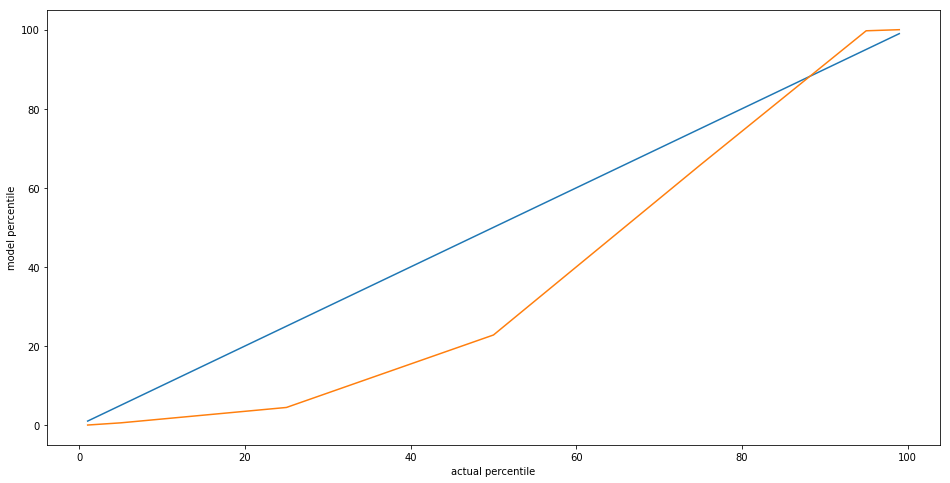

In [10]:
test_smape = metrics.smape(test_samples, y_test_eval)
test_cov, test_perc = metrics.coverage(test_samples, y_test_eval)
test_pinball = metrics.pinball_loss(test_samples, y_test_eval)

print('SMAPE: {}%'.format(test_smape))
print('Pinball Score: {}'.format(test_pinball))
print('Coverage: ')
plt.figure(figsize=(16, 8))
plt.plot(test_perc, test_perc)
plt.plot(test_perc, test_cov)
plt.xlabel('actual percentile')
plt.ylabel('model percentile')
#plt.savefig('qq_test_set.png')

Text(0,0.5,'Push events')

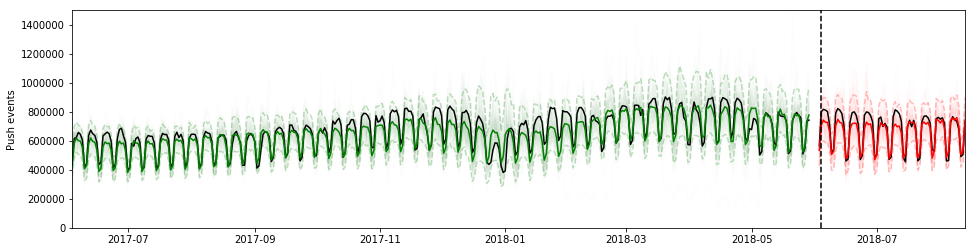

In [11]:
# We're printing the test set data and the predictions for the load data
plt.figure(figsize=(16, 4))

plt.plot(test_dates, test_samples[::20,:,0].T, 'g-', alpha=0.01)
plt.plot(test_dates, y_test_eval, 'k-')
plt.plot(test_dates, test_mean, 'g-')
plt.plot(test_dates, test_uq, 'g--', alpha=0.25)
plt.plot(test_dates, test_lq, 'g--', alpha=0.25)

plt.plot(cf_dates, cf_samples[::20,:,0].T, 'r-', alpha=0.01)
plt.plot(cf_dates, y_cf_eval, 'k-')
plt.plot(cf_dates, cf_mean, 'r-')
plt.plot(cf_dates, cf_uq, 'r--', alpha=0.25)
plt.plot(cf_dates, cf_lq, 'r--', alpha=0.25)

plt.plot([dt.datetime(2018,6,4), dt.datetime(2018,6,4)], [0, 1.5e6], 'k--')

plt.ylim([0, 1.5e6])
plt.xlim([test_dates.values[0], cf_dates.values[-1]])

plt.ylabel('Push events')

#plt.savefig('time_series_plot.png')

Text(0,0.5,'Push event residuals')

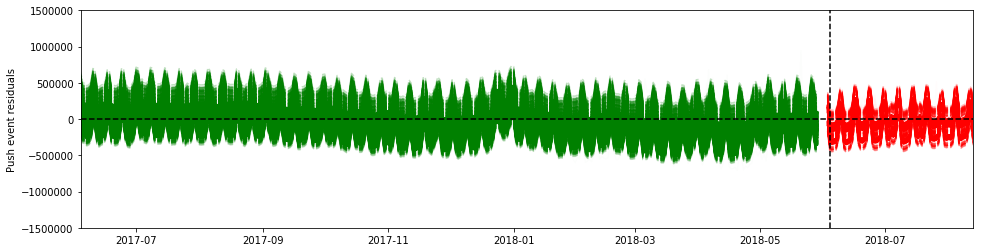

In [14]:
# We're printing the test set data and the predictions for the load data
plt.figure(figsize=(16, 4))

plt.plot(test_dates, (test_samples[::20,:,0]-y_test_eval[:,0]).T, 'g-', alpha=0.01)
plt.plot(test_dates, test_mean[:,0]-y_test_eval, 'g-')
plt.plot(test_dates, test_uq[:,0]-y_test_eval, 'g--', alpha=0.25)
plt.plot(test_dates, test_lq[:,0]-y_test_eval, 'g--', alpha=0.25)

plt.plot(cf_dates, (cf_samples[::20,:,0]-y_cf_eval[:,0]).T, 'r-', alpha=0.01)
plt.plot(cf_dates, cf_mean[:,0]-y_cf_eval, 'r-')
plt.plot(cf_dates, cf_uq[:,0]-y_cf_eval, 'r--', alpha=0.25)
plt.plot(cf_dates, cf_lq[:,0]-y_cf_eval, 'r--', alpha=0.25)

plt.plot([dt.datetime(2018,6,4), dt.datetime(2018,6,4)], [-1.5e6, 1.5e6], 'k--')
plt.plot([test_dates.values[0], cf_dates.values[-1]], [0, 0], 'k--')

plt.ylim([-1.5e6, 1.5e6])
plt.xlim([test_dates.values[0], cf_dates.values[-1]])

plt.ylabel('Push event residuals')

#plt.savefig('time_series_residuals_plot.png')

In [ ]:
# We're printing the test set data and the predictions for the load data
plt.figure(figsize=(16, 4))

plt.plot(test_dates, np.cumsum((test_samples[::20,:,0]-y_test_eval).T, axis=0), 'g-', alpha=0.10)
plt.plot(test_dates, np.cumsum(test_mean[:,0]-y_test_eval), 'g-')
plt.plot(test_dates, np.percentile(np.cumsum((test_samples[::20,:,0]-y_test_eval).T, axis=0), q=5, axis=1), 'g--', alpha=0.5)
plt.plot(test_dates, np.percentile(np.cumsum((test_samples[::20,:,0]-y_test_eval).T, axis=0), q=95, axis=1), 'g--', alpha=0.5)

plt.plot(cf_dates, np.cumsum((cf_samples[::20,:,0]-y_cf_eval).T, axis=0), 'r-', alpha=0.10)
plt.plot(cf_dates, np.cumsum(cf_mean[:,0]-y_cf_eval), 'r-')
plt.plot(cf_dates, np.percentile(np.cumsum((cf_samples[::20,:,0]-y_cf_eval).T, axis=0), q=5, axis=1), 'r--', alpha=0.5)
plt.plot(cf_dates, np.percentile(np.cumsum((cf_samples[::20,:,0]-y_cf_eval).T, axis=0), q=95, axis=1), 'r--', alpha=0.5)

plt.plot([dt.datetime(2018,6,4), dt.datetime(2018,6,4)], [-2e7, 2e7], 'k--')
plt.plot([test_dates.values[0], cf_dates.values[-1]], [0, 0], 'k--')

plt.ylim([-2e7, 2e7])
plt.xlim([test_dates.values[0], cf_dates.values[-1]])

plt.ylabel('Push event cumulative residuals')

#plt.savefig('time_series_cumulative_residulas_plot.png')